In [13]:
# %matplotlib widget
# ==== 1) load packages ====
import numpy as np
import pandas as pd
import math
import glob
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import StandardScaler
import torch
import os

os.chdir(
    # "/home/yliu420/Project/Belief-Elicitation-on-LLM-postrelease/analysis"
    "/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis"
)
from analysis_pkg.preprocess import *
from analysis_pkg.xgboost_model import *
from PCA_TSNE_scoremodel.visualization import *
from llm_belief.analysis import visualize_probability_distribution
ScoreModel = 'XGBoostScore'  # 'MLPAttentionScore'  #'LogisticRegression' #'MLPScore'
torch.manual_seed(2025)

In [14]:
# ==== 2) load data ====
processes = 10
## load profiles and LLM expectations to profiles and df
fl = [f"../output/{i*1000}_{(i+1)*1000}.csv" for i in range(processes)]
# combine all csv files
df = pd.concat([pd.read_csv(f) for f in fl])
profiles = pd.read_csv("../data/profiles_shuffled.csv")

In [15]:
# ==== 3) preprocess data ====
## split to Xi and Xj by odd and even rows
X = preprocess(profiles[:2000*processes])
Xi = X[0:2000*processes:2]
Xj = X[1:2000*processes:2]
y = df["profile_id"].apply(lambda x: 1 if x % 2 == 0 else -1)
y = torch.from_numpy(y.values).float()
P, d = Xi.shape

In [16]:
# ==== 4) train model, and calibration ====
split = int(0.9 * P)
ds_tr = PairwiseDataset(Xi[:split], Xj[:split], y[:split])
ds_va = PairwiseDataset(Xi[split:], Xj[split:], y[split:])
dl_tr = DataLoader(ds_tr, batch_size=64, shuffle=True, num_workers=0)
dl_va = DataLoader(ds_va, batch_size=64, shuffle=False, num_workers=0)

In [17]:
split = int(0.9 * P)
ds_tr = PairwiseDataset(Xi[:split], Xj[:split], y[:split])
ds_va = PairwiseDataset(Xi[split:], Xj[split:], y[split:])
dl_tr = DataLoader(ds_tr, batch_size=64, shuffle=True,  num_workers=0)
dl_va = DataLoader(ds_va, batch_size=64, shuffle=False, num_workers=0)

# —— 训练 XGBoost 排序模型 ——
booster = train_xgb_pairwise(
    Xi_tr=Xi[:split], Xj_tr=Xj[:split], y_tr=y[:split],
    Xi_va=Xi[split:],  Xj_va=Xj[split:],  y_va=y[split:],
    num_boost_round=400,
    early_stopping_rounds=50,
    params={
        "objective": "rank:pairwise",
        "eval_metric": "ndcg@2",
        "tree_method": "hist",     # 如用 GPU: "gpu_hist"
        "max_depth": 6,
        "learning_rate": 0.05,
        "subsample": 0.9,
        "colsample_bytree": 0.8,
        "min_child_weight": 1.0,
        "reg_lambda": 1.0,
    }
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = XGBScorerTorch(booster=booster, d_in=d, device=device)

T = calibrate_temperature(model, dl_va)
print(f"Calibrated Temperature T = {T:.3f}")

[0]	train-ndcg@2:0.95924	valid-ndcg@2:0.95571
[50]	train-ndcg@2:0.97978	valid-ndcg@2:0.96125
[100]	train-ndcg@2:0.98417	valid-ndcg@2:0.96125
[101]	train-ndcg@2:0.98421	valid-ndcg@2:0.96051
Calibrated Temperature T = 0.275


In [18]:
X_eval = torch.randn(10, d)

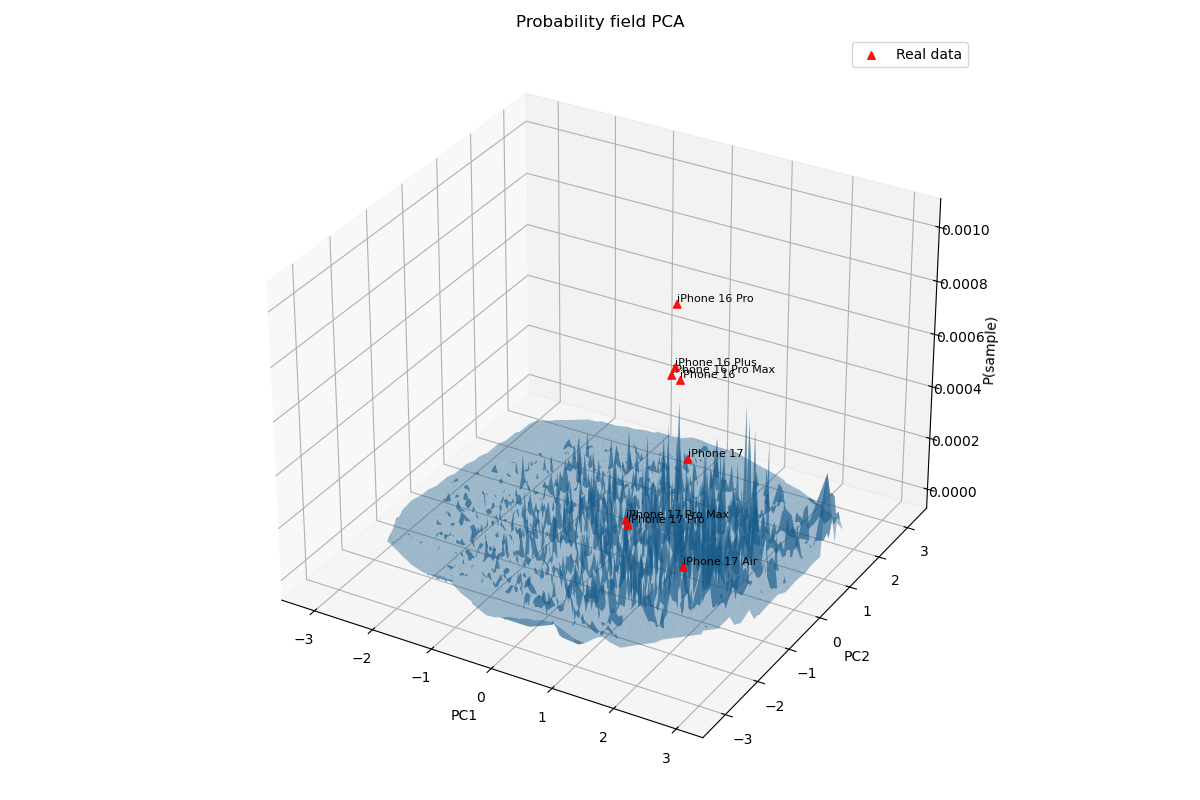

In [19]:
# ==== 6) test on real profiles ====
df_real = pd.read_csv("../data/real_profiles.csv")
X_test = df_real[profiles.columns]
X_test = preprocess_test(X_test)
test_idx = df_real["real model"].tolist()
_, probs, scores = visualize_probability_distribution(
    model, torch.cat([X, X_test], dim=0), T, num_test=X_test.shape[0], test_idx=test_idx, fig_name=f"3d_plot_8_PCA_{ScoreModel}.png",
)


In [20]:
# print the most likely profile
print(profiles.iloc[scores.argmax()])
print('score: ',scores.max())
print("\n====real profiles====\n")
ranks = scores.argsort()[::-1]
for p, i in zip(range(len(ranks)-8, len(ranks)), test_idx):
    rank = np.where(ranks==p)[0][0]+1
    print(f"{i}'s score: {scores[p]:.2f}, rank: {rank}/{len(ranks)}, percentile: {100*(len(ranks)-rank)/len(ranks):.2f}%")

battery life (in hours of video playback)        42.0
screen size (in inches)                           6.1
thickness (in mm)                                8.46
front camera resolution (in MP)                  12.0
rear camera main lens resolution (in MP)         48.0
rear camera longest focal length (in x)           3.3
ultrawide camera                             equipped
Geekbench multicore score                      9400.0
RAM                                                 8
price                                           846.0
Name: 17139, dtype: object
score:  1.2439594

====real profiles====

iPhone 16's score: 1.14, rank: 26/20008, percentile: 99.87%
iPhone 16 Plus's score: 1.14, rank: 28/20008, percentile: 99.86%
iPhone 16 Pro's score: 1.22, rank: 3/20008, percentile: 99.99%
iPhone 16 Pro Max's score: 1.12, rank: 42/20008, percentile: 99.79%
iPhone 17's score: 1.00, rank: 138/20008, percentile: 99.31%
iPhone 17 Air's score: -0.22, rank: 12304/20008, percentile: 38.50%
iPhone

In [21]:
# ==== score all profiles and save ====
scored_df = pd.read_csv("../data/scored_profiles_shuffled.csv")
real_scored_df = pd.read_csv("../data/scored_real_profiles.csv")
X_all = preprocess_test(scored_df.iloc[:,:10])
all_scores, all_probs = score_profiles(model, X_all, T=T)
scored_df['XGBoost'] = all_scores

X_real = preprocess_test(real_scored_df.iloc[:,:10])
real_scores, real_probs = score_profiles(model, X_real, T=T)
real_scored_df['XGBoost'] = real_scores
scored_df.to_csv(f"../data/scored_profiles_shuffled.csv", index=False)
real_scored_df.to_csv(f"../data/scored_real_profiles.csv", index=False)